In [ ]:
from datasets import load_from_disk
from trl import DPOConfig, DPOTrainer
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import torch

from peft import LoraConfig, get_peft_model

In [ ]:
MODEL_ID = "google/gemma-3-1b-it"
MODEL_CACHE_DIRECTORY = "./llm_models_cache"

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    cache_dir=MODEL_CACHE_DIRECTORY,
    device_map="cuda",
    trust_remote_code=True
)

# Enable gradient checkpointing to trade compute for memory
model.gradient_checkpointing_enable()

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    cache_dir=MODEL_CACHE_DIRECTORY,
    trust_remote_code=True
)

train_dataset = load_from_disk("mbpp_custom_dataset_with_correct_gemini_pairs_dpo_ready_with_messages")

In [4]:
# Check max token length of the chosen code
max_chosen_code_length = max([len(tokenizer.encode(item['chosen'])) for item in train_dataset])
print(f"Max chosen code length: {max_chosen_code_length}")

Max chosen code length: 636


In [5]:
max_rejected_code_length = max([len(tokenizer.encode(item['rejected'])) for item in train_dataset])
print(f"Max rejected code length: {max_rejected_code_length}")

Max rejected code length: 585


In [ ]:
# Memory-optimized DPO training configuration
training_args = DPOConfig(
    output_dir="GEMMA3_1B_DPO",

    per_device_train_batch_size=2,        
    gradient_accumulation_steps=16,        
    max_length=1024,                 
    max_prompt_length=1024,
    learning_rate=5e-7,
    num_train_epochs=250,

    gradient_checkpointing=True,
    dataloader_pin_memory=False,
    
    logging_steps=1,
    save_steps=50,
    
    remove_unused_columns=True,
    ddp_find_unused_parameters=False,
)

In [ ]:
# Configure LoRA
lora_config = LoraConfig(
    r=16,                    # Low rank dimension
    lora_alpha=32,           # LoRA scaling parameter
    target_modules=[         # Target modules for LoRA adaptation
        "q_proj",
        "k_proj", 
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_dropout=0.1,        # LoRA dropout
    bias="none",             # Bias type
    task_type="CAUSAL_LM"    # Task type
)

# Apply LoRA to the model
lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()  # Shows how many parameters are trainable

trainable params: 13,045,760 || all params: 1,012,931,712 || trainable%: 1.2879


In [ ]:
# Complete memory-optimized DPO training setup
import gc

# Clear any existing models from memory
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# Create trainer with optimized settings
trainer = DPOTrainer(
    model=lora_model,  # Use LoRA model instead of full model
    args=training_args,  # Use optimized training arguments
    processing_class=tokenizer,
    train_dataset=train_dataset,
)

print("Trainer created")
print(f"Trainable parameters: {sum(p.numel() for p in lora_model.parameters() if p.requires_grad)}")

if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

Trainer created with memory optimizations
Trainable parameters: 13045760
GPU memory allocated: 3.79 GB
GPU memory reserved: 3.81 GB


In [ ]:
trainer.train()

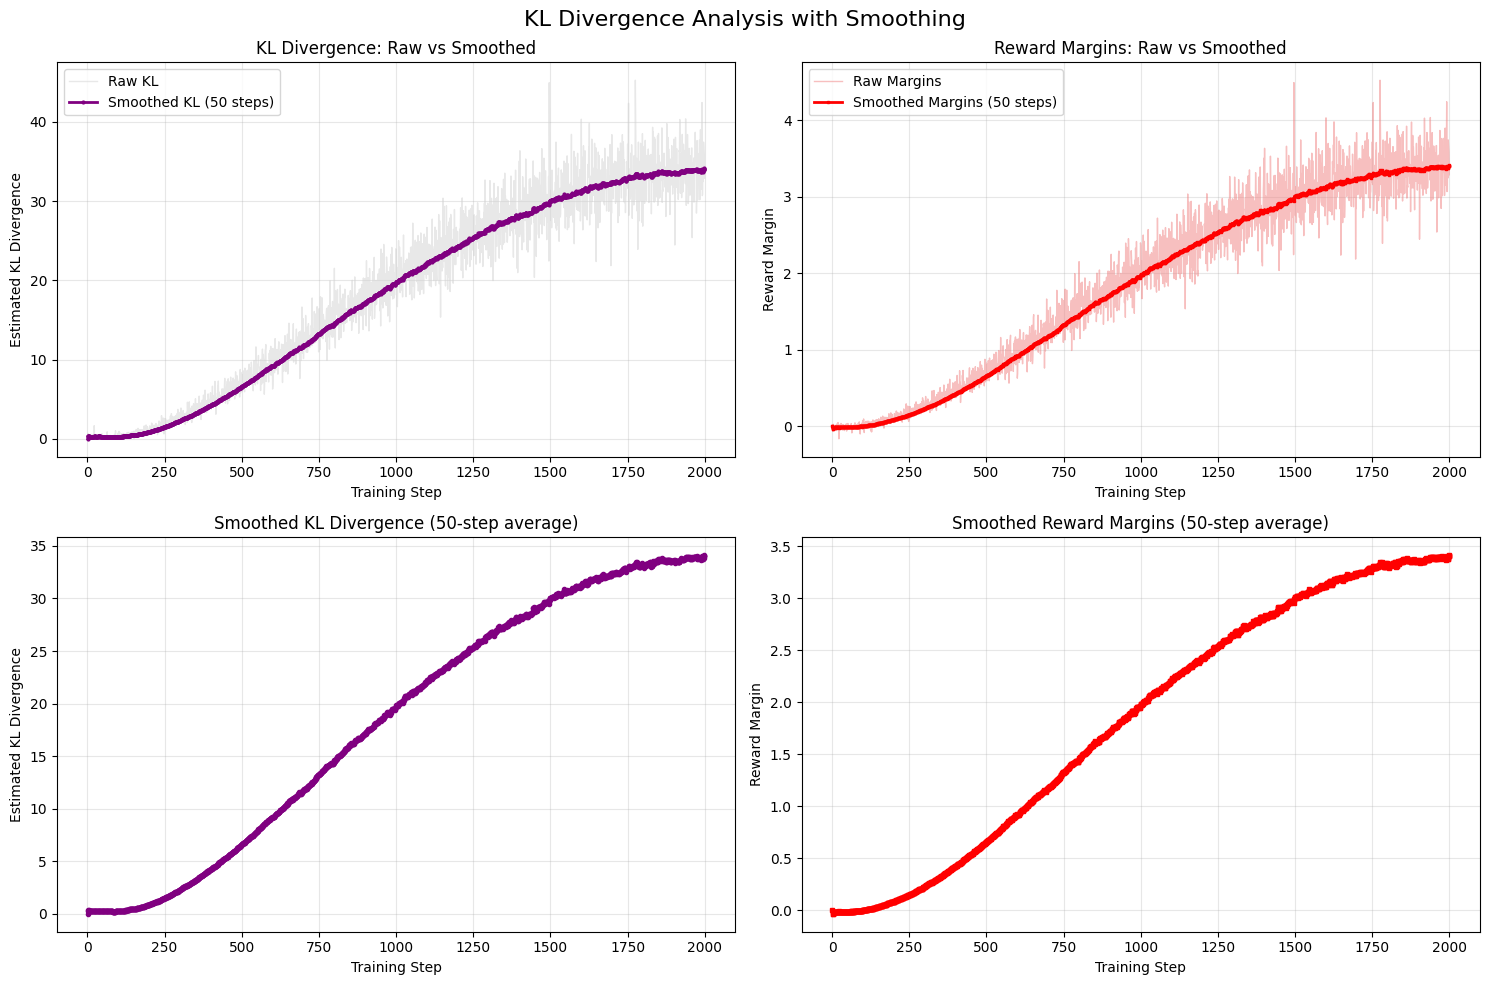


📊 KL Divergence Statistics:
   Raw KL - Mean: 18.672952, Max: 45.249133, Final: nan
   Smoothed KL - Mean: 18.264311, Max: 34.112792, Final: 34.003423
   Raw Margins - Mean: 1.865312, Std: 1.207246
   Smoothed Margins - Mean: 1.823922, Std: 1.191002


In [ ]:
# Compute KL divergence using DPO theory with smoothing
def compute_theoretical_kl_from_dpo_loss(train_logs, beta=0.1, smooth_window=50):
    """
    Estimate KL divergence using DPO loss theory with smoothing
    
    In DPO: loss = -log(σ(β * (log π(y_w|x) - log π(y_l|x) - log π_ref(y_w|x) + log π_ref(y_l|x))))
    
    The KL divergence is related to the difference in log probabilities
    """
    
    if 'loss' in train_logs.columns and 'rewards/margins' in train_logs.columns:
        
        # Extract components
        loss = train_logs['loss']
        reward_margin = train_logs['rewards/margins']
        
        # Approximate KL using the relationship in DPO
        # In DPO, the implicit reward is r(x,y) = β * log(π(y|x)/π_ref(y|x)) + constant
        # So KL ≈ reward_margin / β
        
        estimated_kl = np.abs(reward_margin) / beta
        
        # Apply smoothing using rolling average
        estimated_kl_smooth = estimated_kl.rolling(window=smooth_window, min_periods=1).mean()
        reward_margin_smooth = reward_margin.rolling(window=smooth_window, min_periods=1).mean()
        
        return estimated_kl, estimated_kl_smooth, reward_margin, reward_margin_smooth
    
    return None, None, None, None

logs = trainer.state.log_history
df = pd.DataFrame(logs)
train_logs = df[df['step'].notna()].copy()

# Compute theoretical KL with smoothing
raw_kl, smooth_kl, raw_margins, smooth_margins = compute_theoretical_kl_from_dpo_loss(
    train_logs, beta=0.1, smooth_window=50
)

if smooth_kl is not None:
    plt.figure(figsize=(15, 10))
    
    # Plot 1: KL Divergence - Raw vs Smoothed
    plt.subplot(2, 2, 1)
    plt.plot(train_logs['step'], raw_kl, 'lightgray', alpha=0.5, linewidth=1, label='Raw KL')
    plt.plot(train_logs['step'], smooth_kl, 'purple', linewidth=2, marker='o', markersize=2, label='Smoothed KL (50 steps)')
    plt.title('KL Divergence: Raw vs Smoothed')
    plt.xlabel('Training Step')
    plt.ylabel('Estimated KL Divergence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Reward Margins - Raw vs Smoothed  
    plt.subplot(2, 2, 2)
    plt.plot(train_logs['step'], raw_margins, 'lightcoral', alpha=0.5, linewidth=1, label='Raw Margins')
    plt.plot(train_logs['step'], smooth_margins, 'red', linewidth=2, marker='s', markersize=2, label='Smoothed Margins (50 steps)')
    plt.title('Reward Margins: Raw vs Smoothed')
    plt.xlabel('Training Step')
    plt.ylabel('Reward Margin')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Smoothed KL only (cleaner view)
    plt.subplot(2, 2, 3)
    plt.plot(train_logs['step'], smooth_kl, 'purple', linewidth=2, marker='o', markersize=3)
    plt.title('Smoothed KL Divergence (50-step average)')
    plt.xlabel('Training Step')
    plt.ylabel('Estimated KL Divergence')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Smoothed Margins only (cleaner view)
    plt.subplot(2, 2, 4)
    plt.plot(train_logs['step'], smooth_margins, 'red', linewidth=2, marker='s', markersize=3)
    plt.title('Smoothed Reward Margins (50-step average)')
    plt.xlabel('Training Step')
    plt.ylabel('Reward Margin')
    plt.grid(True, alpha=0.3)
    
    plt.suptitle('KL Divergence Analysis with Smoothing', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print KL statistics for both raw and smoothed
    print(f"\n📊 KL Divergence Statistics:")
    print(f"   Raw KL - Mean: {raw_kl.mean():.6f}, Max: {raw_kl.max():.6f}, Final: {raw_kl.iloc[-1]:.6f}")
    print(f"   Smoothed KL - Mean: {smooth_kl.mean():.6f}, Max: {smooth_kl.max():.6f}, Final: {smooth_kl.iloc[-1]:.6f}")
    print(f"   Raw Margins - Mean: {raw_margins.mean():.6f}, Std: {raw_margins.std():.6f}")
    print(f"   Smoothed Margins - Mean: {smooth_margins.mean():.6f}, Std: {smooth_margins.std():.6f}")
    
else:
    print("Cannot compute theoretical KL - missing required metrics")

In [ ]:
# Save the fine-tuned LoRA model
lora_model.save_pretrained("gemma-3-1b-dpo-250-epochs")